In [457]:
import textacy
import pandas as pd
import spacy
from subject_verb_object_extract import findSVOs
import matplotlib.pyplot as plt
import numpy as np

nlp = spacy.load('en_core_web_lg')

In [458]:
train1 = pd.read_csv('../Input_Data/e-SNLI/dataset/esnli_train_1.csv')
train2 = pd.read_csv('../Input_Data/e-SNLI/dataset/esnli_train_2.csv')
train = pd.concat([train1, train2])
dev = pd.read_csv('../Input_Data/e-SNLI/dataset/esnli_dev.csv')
test = pd.read_csv('../Input_Data/e-SNLI/dataset/esnli_test.csv')

train = train.head(1000)

In [459]:
def extract_SVO(text):
	tuples_list = list()
	tuples = textacy.extract.subject_verb_object_triples(text)
	if tuples:
		tuples_to_list = list(tuples)
		tuples_list.append(tuples_to_list)
	return tuples_list

In [460]:
def findLoc(text):
	for token in text:
		if token.dep_ == 'prep' and token.lemma_ in ['on', 'in']:
			return list(token.subtree)

In [671]:
def transform_svo_to_nlp(svos):
	res = list()
	for svo in svos:
		res.append([[token for token in nlp(sub_part)] for sub_part in svo])
	return res

In [672]:
SVO_list = []
train['nlp_s1'] = train['Sentence1'].apply(nlp)
train['nlp_s2'] = train['Sentence2'].apply(nlp)
train['svo_s1'] = train['nlp_s1'].apply(findSVOs).apply(transform_svo_to_nlp)
train['svo_s2'] = train['nlp_s2'].apply(findSVOs).apply(transform_svo_to_nlp)
train['loc_s1'] = train['nlp_s1'].apply(findLoc)
train['loc_s2'] = train['nlp_s2'].apply(findLoc)

In [673]:
train[['svo_s1', 'loc_s1', 'svo_s2', 'loc_s2']]

,svo_s1,loc_s1,svo_s2,loc_s2
0,"[[[A, person, on, a, horse], [jumps]]]","[on, a, horse]","[[[A, person], [training], [his, horse]]]",None
1,"[[[A, person, on, a, horse], [jumps]]]","[on, a, horse]",[],None
2,"[[[A, person, on, a, horse], [jumps]]]","[on, a, horse]","[[[A, person], [is]]]","[on, a, horse]"
3,"[[[Children], [waving]]]",None,"[[[They], [smiling]]]",None
4,"[[[Children], [waving]]]",None,"[[[There], [are], [children, present]]]",None
...,...,...,...,...
995,[],None,"[[[The, child], [has], [a, clean, face]]]",None
996,[],None,"[[[The, child], [had], [milk]]]",None
997,"[[[Two, barefoot, men], [playing]]]","[on, a, green, lawn]","[[[Two, men], [are]]]","[on, the, lawn]"
998,"[[[Two, barefoot, men], [playing]]]","[on, a, green, lawn]","[[[Two, men, in, sandles], [are]]]","[in, sandles]"


In [92]:
counter = 0
for row in train.itertuples():
	if len(row.svo_s1) == 0 or len(row.svo_s2) == 0:
		counter += 1
print(counter / train.shape[0])

0.099


In [109]:
for a in train.nlp_s1:
	for token in a:
		if token.dep_ == 'prep':
			print(list(token.subtree))

[on, a, horse]
[over, a, broken, down, airplane]
[on, a, horse]
[over, a, broken, down, airplane]
[on, a, horse]
[over, a, broken, down, airplane]
[at, camera]
[at, camera]
[at, camera]
[on]
[in, the, middle, of, a, red, bridge]
[of, a, red, bridge]
[on]
[in, the, middle, of, a, red, bridge]
[of, a, red, bridge]
[on]
[in, the, middle, of, a, red, bridge]
[of, a, red, bridge]
[with, his, orange, juice]
[at, a, small, table, in, a, coffee, shop]
[in, a, coffee, shop]
[in, bright, colored, shirts]
[in, the, background]
[with, his, orange, juice]
[at, a, small, table, in, a, coffee, shop]
[in, a, coffee, shop]
[in, bright, colored, shirts]
[in, the, background]
[with, his, orange, juice]
[at, a, small, table, in, a, coffee, shop]
[in, a, coffee, shop]
[in, bright, colored, shirts]
[in, the, background]
[in, a, restaurant, setting]
[of, them]
[in, a, restaurant, setting]
[of, them]
[in, a, restaurant, setting]
[of, them]
[at, a, restaurant]
[at, a, restaurant]
[at, a, restaurant]
[with, blo

In [113]:
temp = list()
for a in train.nlp_s1:
	temp1 = list()
	for token in a:
		if token.dep_ == 'prep' and token.lemma_ in ['on', 'in']:
			temp1.append(list(token.subtree))
	if len(temp1) != 0:
		temp.append(temp1)

In [114]:
len(temp)

600

## Extract Clothing

### Train Classifier

In [434]:
clothing_words = ['jeans', 'shirt', 'shirts', 'boot', 'boots', 'jacket', 'jackets', 'glove', 'gloves', 'shoe', 'shoes', 'sweater', 'sweaters', 'hat', 'hats', 'skirt', 'skirts', 'beanie', 'beanies', 'blouse', 'blouses', 'tank top', 'tank tops', 'shorts', 'trousers', 'pants', 'skirt', 'skirts', 'jumper', 'suit', 'suits', 'uniform', 'uniforms', 'dress', 'dresses', 'coat', 'coats', 'pullover', 'pullovers', 'sweatshirt', 'sweatshirts', 'cardigan', 'cardigans', 'sandle', 'sandles', 'raincoat', 'raincoats', 'swimsuit', 'scarf', 'hoodie']
other_words = [word for word in list(nlp.vocab.strings) if word not in clothing_words]

In [435]:
def cosine_sim_clothing_word(word, clothing_vectors):
	v1 = nlp.vocab[word].vector
	return max([np.dot(v1, v2)  / (np.linalg.norm(v1) * np.linalg.norm(v2)) for v2 in clothing_vectors])

In [436]:
all_terms = pd.Series(nlp.vocab.strings)
clothing_vectors = [nlp.vocab[clothing_word].vector for clothing_word in clothing_words]

In [437]:
res = all_terms.apply(cosine_sim_clothing_word, clothing_vectors=clothing_vectors)

In [438]:
label = np.array([1 if word in clothing_words else 0 for word in all_terms])

In [439]:
all_terms = all_terms[[not val for val in res.isna()]]
label = label[[not val for val in res.isna()]]
res = res[[not val for val in res.isna()]]
res = res.reset_index()
res = res.drop(["index"], axis=1)
all_terms = all_terms.reset_index()
all_terms = all_terms.drop(["index"], axis=1)

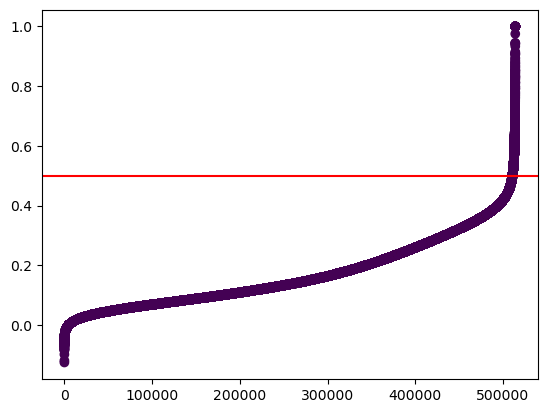

In [449]:
plt.scatter(range(len(res)), np.sort(res[0]), c=label)
plt.axhline(y=0.7, color="red")

In [709]:
def cosine_sim(v1, v2):
	return np.dot(v1, v2)  / (np.linalg.norm(v1) * np.linalg.norm(v2))

clothing_vectors = [nlp.vocab[clothing_word].vector for clothing_word in clothing_words]

def findClothing(text):
	# https://stackoverflow.com/questions/53493052/any-elegant-solution-for-finding-compound-noun-adjective-pairs-from-sentence-by
	for token in text:
		if any(np.array([cosine_sim(token.vector, v2) for v2 in clothing_vectors]) > 0.7):
			comps = [j for j in token.children if j.pos_ in ['ADJ', 'NOUN', 'PROPN']]
			if len(comps) > 0:
				return comps + [token, ]
			else:
				return [token, ]

In [710]:
train['clo_s1'] = train['nlp_s1'].apply(findClothing)
train['clo_s2'] = train['nlp_s2'].apply(findClothing)

In [621]:
train[['svo_s1', 'loc_s1', 'clo_s1']]

,svo_s1,loc_s1,clo_s1
0,"[((A, person, on, a, horse), (jumps))]","[on, a, horse]",None
1,"[((A, person, on, a, horse), (jumps))]","[on, a, horse]",None
2,"[((A, person, on, a, horse), (jumps))]","[on, a, horse]",None
3,"[((Children), (waving))]",None,None
4,"[((Children), (waving))]",None,None
...,...,...,...
995,[],None,None
996,[],None,None
997,"[((Two, barefoot, men), (playing))]","[on, a, green, lawn]",None
998,"[((Two, barefoot, men), (playing))]","[on, a, green, lawn]",None


In [715]:
j = 0
for row in train.itertuples():
	i_s1 = 0
	i_s2 = 0
	if row.clo_s1 is not None:
		for svo in row.svo_s1:
			keep_index = [token.lemma_ not in [clo.lemma_ for clo in row.clo_s1] for token in svo[0]]
			train.iloc[j].svo_s1[i_s1][0] = np.array(row.svo_s1[i_s1][0])[keep_index]
			i_s1 += 1
	if row.clo_s2 is not None:
		for svo in row.svo_s2:
			keep_index = [token.lemma_ not in [clo.lemma_ for clo in row.clo_s2] for token in svo[0]]
			train.iloc[j].svo_s2[i_s2][0] = np.array(row.svo_s2[i_s2][0])[keep_index]
			i_s2 += 1
	j += 1

In [712]:
train[['svo_s1', 'loc_s1', 'clo_s1']]

,svo_s1,loc_s1,clo_s1
0,"[[[A, person, on, a, horse], [jumps]]]","[on, a, horse]",None
1,"[[[A, person, on, a, horse], [jumps]]]","[on, a, horse]",None
2,"[[[A, person, on, a, horse], [jumps]]]","[on, a, horse]",None
3,"[[[Children], [waving]]]",None,None
4,"[[[Children], [waving]]]",None,None
...,...,...,...
995,[],None,None
996,[],None,None
997,"[[[Two, barefoot, men], [playing]]]","[on, a, green, lawn]",None
998,"[[[Two, barefoot, men], [playing]]]","[on, a, green, lawn]",None
